In [148]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta
from sklearn.model_selection import KFold
from factor_analyzer import factor_analyzer, FactorAnalyzer
from sklearn.decomposition import PCA
import import_ipynb
import SplitData as SD
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import RFE

# Load Data

In [2]:
inputs = {}
for file_name in os.listdir('./New_Data/'):
    if file_name.startswith('.'):
        continue
    name = file_name.replace('.csv', '')
    path = './New_Data/' + file_name
    inputs[name] = pd.read_csv(path, index_col = 0)

## Processing Data

In [3]:
SD.splitActivities(inputs)
SD.splitAudio(inputs)
SD.splitDark(inputs)
SD.splitConversation(inputs)

### Load Processed Data

In [4]:
inputs = {}
for file_name in os.listdir('./Final_Data/'):
    if file_name.startswith('.'):
        continue
    name = file_name.replace('.csv', '')
    path = './Final_Data/' + file_name
    df = pd.read_csv(path, index_col = 0)
    inputs[name]= df.replace(0, np.nan)
inputs['conversation_freq']

,week1,week2,week3,week4,week5,week6,week7,week8,week9,week10
u00,128.0,217,255.0,209,225,281.0,275.0,176.0,167.0,178.0
u01,155.0,255,260.0,328,357,94.0,257.0,306.0,64.0,103.0
u02,80.0,167,159.0,214,136,189.0,106.0,108.0,106.0,218.0
u03,27.0,57,63.0,92,85,80.0,42.0,19.0,13.0,NaN
u04,187.0,329,309.0,345,303,353.0,376.0,399.0,136.0,NaN
u05,123.0,206,153.0,156,213,228.0,163.0,143.0,135.0,120.0
u07,156.0,341,289.0,227,37,140.0,128.0,55.0,NaN,NaN
u08,120.0,232,271.0,268,339,297.0,317.0,292.0,299.0,125.0
u09,132.0,212,275.0,282,201,255.0,253.0,253.0,235.0,171.0
u10,152.0,266,245.0,230,257,213.0,233.0,200.0,311.0,153.0


In [5]:
def fillMissing(df):
    df = df.transpose().interpolate(method='linear').transpose()
    return df.transpose().interpolate(method = 'linear', limit_direction='backward').transpose()

In [6]:
for key in inputs.keys():
    if inputs[key].shape[1] != 1:
        inputs[key] = fillMissing(inputs[key])

### Split into positive negative and flourishing score dataframes

In [7]:
flourishing = pd.read_csv('./StudentLife_Dataset/Outputs/FlourishingScale.csv')
panas = pd.read_csv('./StudentLife_Dataset/Outputs/panas.csv')
positive_score=['uid', 'Interested', 'Strong', 'Enthusiastic', 'Proud', 'Alert', 'Inspired', 'Determined ', 'Attentive', 'Active ']
negative_score=['uid', 'Distressed', 'Upset', 'Guilty', 'Scared', 'Hostile ', 'Irritable','Nervous', 'Jittery', 'Afraid ']
df_flour_post = pd.DataFrame()
df_pos_post = pd.DataFrame()
df_neg_post = pd.DataFrame()
   
for i in range(60):
    temp_flour_post = (flourishing.loc[flourishing['uid'] == 'u' + str(f"{i:02d}")].loc[flourishing['type'] == 'post']).drop(columns='type')
    df_flour_post = pd.concat([df_flour_post, temp_flour_post], axis = 0)
    
    temp_post = panas.loc[panas['uid'] == 'u' + str(f"{i:02d}")].loc[panas['type'] == 'post']
    df1_post = temp_post[positive_score]
    df2_post = temp_post[negative_score]
    df_pos_post = pd.concat([df_pos_post, df1_post], axis=0)
    df_neg_post = pd.concat([df_neg_post, df2_post], axis=0)
df_flour_post = df_flour_post.set_index(keys='uid')
df_pos_post = df_pos_post.set_index(keys='uid')
df_neg_post = df_neg_post.set_index(keys = 'uid')
df_flour_post = df_flour_post.dropna()
df_pos_post = df_pos_post.dropna()
df_neg_post = df_neg_post.dropna()

In [8]:
df_pos_post.sum(axis=1).mean(axis=0)

28.55263157894737

In [9]:
df_neg_post.sum(axis=1).mean(axis=0)

21.666666666666668

# Factor Analysis

### Factor Analysis on flourishing score ###

eigen value: [4.72966388 0.98291258 0.77622504 0.64529042 0.33397926 0.24749074
 0.20296179 0.08147629]
[[0.31688052 0.21432535 0.19923823 0.66261105]
 [0.2585026  0.93824972 0.2168432  0.11459462]
 [0.07473832 0.2211992  0.71782709 0.53531789]
 [0.20701157 0.68741963 0.19542953 0.26829092]
 [0.59399358 0.10935955 0.45331901 0.27049275]
 [0.7777158  0.52599042 0.12197477 0.08841656]
 [0.75956878 0.24233212 0.22033764 0.38302414]
 [0.42648854 0.31416609 0.70535661 0.06603291]]


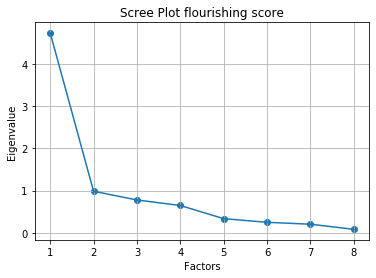

In [10]:
fa = FactorAnalyzer(rotation='varimax', n_factors = 4)
fa.fit(df_flour_post)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
print('eigen value:',ev)
print(fa.loadings_)
fa.get_factor_variance()
fa.get_communalities()
#df_flour.corr()
plt.scatter(range(1,df_flour_post.shape[1]+1),ev)
plt.plot(range(1,df_flour_post.shape[1]+1),ev)
plt.title('Scree Plot flourishing score')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

### Factor Analysis on positive score ###

[[ 0.27470964  0.53567573  0.32751873  0.26853457  0.15876631]
 [ 0.18421643  0.13105905  0.14886771  0.94707978  0.16116346]
 [ 0.83856084  0.16591595  0.31863084  0.02378699  0.08972149]
 [ 0.72677121  0.22213152  0.14030992  0.27696509  0.13497939]
 [ 0.09584669  0.68381857  0.03747196  0.03495601  0.10558782]
 [ 0.30612487  0.15686176  0.92098868  0.16943945  0.10464141]
 [ 0.53205036  0.54574023  0.07730634  0.31569827 -0.06703295]
 [ 0.34710601  0.43963834  0.29560235  0.01634004  0.23435742]
 [ 0.11117992  0.17286007  0.10713549  0.15314332  0.95946516]]


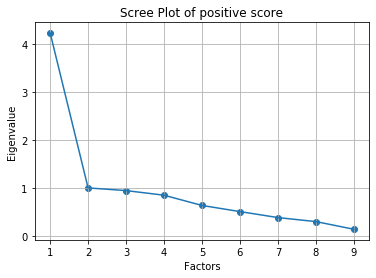

In [11]:
fa = FactorAnalyzer(rotation='varimax', n_factors = 5)
fa.fit(df_pos_post)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

print(fa.loadings_)
fa.get_factor_variance()
df_pos_post.corr()
plt.scatter(range(1,df_pos_post.shape[1]+1),ev)
plt.plot(range(1,df_pos_post.shape[1]+1),ev)
plt.title('Scree Plot of positive score')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

### Factor Analysis on negative score ###

[[ 0.37626204  0.01805423  0.61551903  0.11402431  0.12347411]
 [ 0.23894706  0.23231523  0.9362824  -0.02442456  0.09137572]
 [-0.00779734  0.21617853  0.03522102  0.62532704 -0.01238882]
 [ 0.17711167  0.90800036  0.09656557  0.30352627  0.20372337]
 [ 0.5964478   0.1717456   0.24326655  0.02876155  0.22868964]
 [ 0.96297948  0.10067493  0.20400468  0.13991971  0.0806794 ]
 [ 0.4930571   0.36090192  0.30398745 -0.05111242  0.63124702]
 [ 0.6511574   0.19583206  0.25150032 -0.1864071   0.06473958]
 [ 0.1885959   0.87789882  0.15735423  0.13140605  0.04686113]]


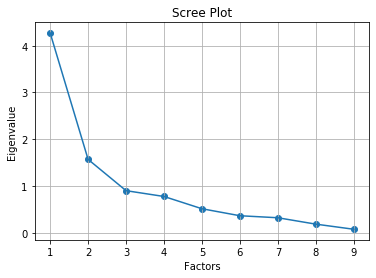

In [12]:
fa = FactorAnalyzer(rotation='varimax', n_factors = 5)
fa.fit(df_neg_post)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

print(fa.loadings_)
fa.get_factor_variance()
df_neg_post.corr()
plt.scatter(range(1,df_neg_post.shape[1]+1),ev)
plt.plot(range(1,df_neg_post.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

### INPUT DATA for Flourishing Data###

In [13]:
## Look for people quit for post flourishing score testing ##
full_ids = []
for i in range(60):
    full_ids.append('u' + str(f"{i:02d}"))
ids_flour_post = df_flour_post.index.to_numpy()
quit_ids = list(set(full_ids) - set(ids_flour_post))
#print(quit_ids)
### Delete people quit, from dataframe ###
input_keys = inputs.keys()
flour_input = {}
for key in input_keys:
    flour_input[key] = inputs[key].drop(quit_ids, errors='ignore')
flour_input

{'dark_freq':      week1  week2  week3  week4  week5  week6  week7  week8  week9  week10
 u00   15.0   24.0   22.0   25.0   24.0   20.0   26.0   12.0    5.0    11.0
 u01   21.0   22.0   27.0   22.0   28.0   26.0   11.0   30.0   12.0     6.0
 u02   14.0   20.0   25.0   18.0   20.0   20.0   19.0   20.0   16.0    15.0
 u03   11.0    7.0    9.0   12.0    6.0    9.0    5.0    3.0    1.0     1.0
 u04   21.0   33.0   32.0   32.0   30.0   30.0   38.0   38.0   14.0    14.0
 u05   15.0   28.0   23.0   16.0   21.0   23.0   12.0   16.0    6.0    10.0
 u07   14.0   27.0   22.0   28.0   17.0   18.0   19.0    7.0    7.0     7.0
 u09   11.0   18.0   17.0   18.0   23.0   19.0   23.0   23.0   27.0    12.0
 u10   24.0   35.0   22.0   19.0   21.0   26.0   20.0   20.0   17.0    13.0
 u14   22.0   24.0   18.0   21.0   16.0   16.0   17.0    9.0    3.0     1.0
 u15   12.0    8.0    7.0    6.0    3.0    3.0    3.0    6.0    3.5     1.0
 u16   20.0   17.0   25.0   20.0   12.0   16.0   18.0   11.0   18.0     6.0

In [14]:
### 3 dimensional Data with (number of participants * number of weeks * number of features) ###
nWeeks = 10
input_keys = ['walk','run', 'noise', 'conversation_freq', 'conversation_time', 'dark_freq', 'dark_time']
n_features = len(input_keys)
data_3d = np.zeros((len(ids_flour_post), nWeeks, n_features))
for nWeek in range(10):
    n = 0
    for key in input_keys:
        data_3d[:, nWeek , n] = flour_input[key].iloc[:, nWeek]
        n += 1
        
        
file = open('data_y.pickle', 'wb')
pickle.dump(np_df, file)
file.close()

file2 = open('data_x.pickle', 'wb')
pickle.dump(data_3d, file2)
file2.close()

PermissionError: [Errno 13] Permission denied: 'data_y.pickle'

In [15]:
# ### Defining Classes ###
# df_total_flour[df_total_flour.iloc[:, 0] <= m] = 0
# df_total_flour[df_total_flour.iloc[:, 0] > m] = 1 
# df_class = pd.DataFrame(columns=['class'])
# for uid in df_total_flour.index:
#     s1 = int(df_total_flour.loc[uid])
#     s2 = int(df_pos_post.loc[uid])
#     if s1 is None or s2 is None:
#         continue

#     # No confidence and Negative
#     if s1 == 0 and s2 == 0:
#         df_class.loc[uid] = 1.0
#     # confidence and Negative
#     if s1 == 1 and s2==0:
#         df_class.loc[uid] = 2.0
#     # No confidence and Positive
#     if s1 == 0 and s2==1:
#         df_class.loc[uid] = 3.0
#     # confidence and Positive
#     if s1 == 1 and s2==1:
#         df_class.loc[uid] = 4.0
#df_class

# METHODS #

### BINARIZATION ###

In [15]:
### Convert score to binary data ###
def binarize(df, threshold):
    m = threshold
    if m < 1:
        df[df.iloc[:, 0] > m] = 1
        df[df.iloc[:, 0] <= m] = 0
    else:
        df[df.iloc[:, 0] <= m] = 0
        df[df.iloc[:, 0] > m] = 1
    return df

## Method 1

### LSTM 

In [16]:
import pickle
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset, TensorDataset
from sklearn.model_selection import train_test_split

In [17]:
basic = os.getcwd()
save_path = basic + "/bilstm_params.pkl"
data_path = basic + "/data_x.pickle"
label_path = basic + "/data_y.pickle"

In [18]:
data = pickle.load(open(data_path, "rb"))
label = pickle.load(open(label_path, "rb")).reshape(37)

In [19]:
# Hyper Parameters
EPOCH = 10               # train the training data n times
BATCH_SIZE = 8
HIDDEN_SIZE = 16
TIME_STEP = data.shape[1]         # rnn time step / image height
INPUT_SIZE = data.shape[2]         # rnn input size / image width
LR = 0.01               # learning rate

In [20]:
train_x, valid_x, train_y, valid_y = train_test_split(data, label, train_size=0.8, random_state=100)

In [21]:
torch.manual_seed(999)    # reproducible

In [22]:
# Data Loader for easy mini-batch return in training
train_x, train_y = torch.from_numpy(train_x), torch.from_numpy(train_y)
valid_x, valid_y = torch.from_numpy(valid_x), torch.from_numpy(valid_y)
train_loader = torch.utils.data.DataLoader(dataset=TensorDataset(train_x, train_y), 
                                           batch_size=BATCH_SIZE, shuffle=True)

In [23]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BiRNN(nn.Module):
    
    def __init__(self, hidden_size=HIDDEN_SIZE, num_layers=1, num_classes=2):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(INPUT_SIZE, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
        self.hidden = None
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, self.hidden = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [24]:
rnn = BiRNN()
print(rnn)

BiRNN(
  (lstm): LSTM(7, 16, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


In [25]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all rnn parameters
loss_func = nn.CrossEntropyLoss()

Epoch:  0 | train loss: 0.6703 | valid loss: 0.7235 | train accuracy: 0.5517 | valid accuracy: 0.3750
Epoch:  1 | train loss: 0.5679 | valid loss: 0.6912 | train accuracy: 0.5517 | valid accuracy: 0.3750
Epoch:  2 | train loss: 0.5424 | valid loss: 0.7400 | train accuracy: 0.5517 | valid accuracy: 0.3750
Epoch:  3 | train loss: 0.6008 | valid loss: 0.6462 | train accuracy: 0.7586 | valid accuracy: 0.6250
Epoch:  4 | train loss: 0.6591 | valid loss: 0.5997 | train accuracy: 0.6552 | valid accuracy: 0.6250
Epoch:  5 | train loss: 0.6715 | valid loss: 0.6023 | train accuracy: 0.6897 | valid accuracy: 0.6250
Epoch:  6 | train loss: 0.4588 | valid loss: 0.6525 | train accuracy: 0.6897 | valid accuracy: 0.6250
Epoch:  7 | train loss: 0.5639 | valid loss: 0.6998 | train accuracy: 0.7241 | valid accuracy: 0.6250
Epoch:  8 | train loss: 0.5756 | valid loss: 0.6962 | train accuracy: 0.6897 | valid accuracy: 0.5000
Epoch:  9 | train loss: 0.5729 | valid loss: 0.6380 | train accuracy: 0.7586 | val

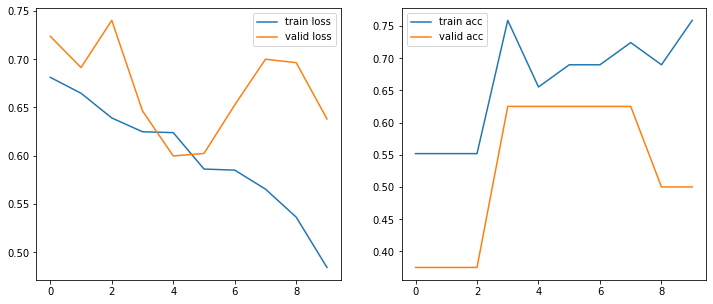

In [26]:
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.float())                       # batch x
        b_y = Variable(y.long())                        # batch y
        output = rnn(b_x)                            # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients
        if step % 5 == 0:
            valid_output = rnn(Variable(valid_x.float()))
            train_output = rnn(Variable(train_x.float()))
            train_loss = loss_func(train_output, train_y.long())
            valid_loss = loss_func(valid_output, valid_y.long())
            train_losses.append(train_loss.data)
            valid_losses.append(valid_loss.data)
            
            pred_train = torch.max(train_output, 1)[1].data.numpy().squeeze()
            pred_valid = torch.max(valid_output, 1)[1].data.numpy().squeeze()
            train_accu = sum(pred_train == train_y.data.numpy()) / float(train_y.numpy().size)
            valid_accu = sum(pred_valid == valid_y.data.numpy()) / float(valid_y.numpy().size)
            train_accuracy.append(train_accu)
            valid_accuracy.append(valid_accu)
            
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| valid loss: %.4f' % valid_loss.data, 
                  '| train accuracy: %.4f' % train_accu, '| valid accuracy: %.4f' % valid_accu)

ax1.plot(train_losses, label="train loss")
ax1.plot(valid_losses, label="valid loss")
ax1.legend()
ax2.plot(train_accuracy, label="train acc")
ax2.plot(valid_accuracy, label="valid acc")
ax2.legend()

## Method 2


### Get Hidden Gate from LSTM

In [27]:
def getHidden():
    rnn_knn = BiRNN()
    optimizer = torch.optim.Adam(rnn_knn.parameters(), lr=LR)   # optimize all rnn parameters
    loss_func = nn.CrossEntropyLoss()
    train_losses = []
    valid_losses = []
    train_accuracy = []
    valid_accuracy = []
    # training and testing
    for epoch in range(EPOCH):
        data1 = torch.tensor(data)
        y1 = torch.tensor(label)
        b_x = Variable(data1.float())                       # batch x
        b_y = Variable(y1.long())                        # batch y
        output = rnn_knn(b_x)                            # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
    data_week10 = rnn_knn.hidden[1][0]
    data_week10 = data_week10.detach().numpy()
    return data_week10

### Input and Output

In [295]:
## Look for people quit for post flourishing score testing ##
full_ids = []
for i in range(60):
    full_ids.append('u' + str(f"{i:02d}"))
ids_flour_post = df_flour_post.index.to_numpy()
quit_ids = list(set(full_ids) - set(ids_flour_post))

### Delete people quit, from dataframe ###
input_keys = inputs.keys()
flour_input = {}
for key in input_keys:
    flour_input[key] = inputs[key].drop(quit_ids, errors='ignore')
for key in flour_input.keys():
    flour_input[key] = flour_input[key].sum(axis=1).to_frame()
X_flour = pd.DataFrame(columns=None)

## input and label for flourishing score
for key in flour_input:
    flour_input[key].columns = [key]
    X_flour = pd.concat([X_flour, flour_input[key]], axis = 1)
label_flour = binarize(df_flour_post.sum(axis = 1).to_frame(0), 44)

In [296]:
## Look for people quit for post flourishing score testing ##
full_ids = []
for i in range(60):
    full_ids.append('u' + str(f"{i:02d}"))
ids_pos_post = df_pos_post.index.to_numpy()
quit_ids = list(set(full_ids) - set(ids_pos_post))

### Delete people quit, from dataframe ###
input_keys = inputs.keys()
pos_input = {}
for key in input_keys:
    pos_input[key] = inputs[key].drop(quit_ids, errors='ignore')
for key in pos_input.keys():
    pos_input[key] = pos_input[key].sum(axis=1).to_frame()
X_pos = pd.DataFrame(columns=None)

## input and label for flourishing score
for key in pos_input:
    pos_input[key].columns = [key]
    X_pos = pd.concat([X_pos, pos_input[key]], axis = 1)
label_pos = binarize(df_pos_post.sum(axis = 1).to_frame(0), 29)

In [297]:
## Look for people quit for post flourishing score testing ##
full_ids = []
for i in range(60):
    full_ids.append('u' + str(f"{i:02d}"))
ids_neg_post = df_neg_post.index.to_numpy()
quit_ids = list(set(full_ids) - set(ids_neg_post))

### Delete people quit, from dataframe ###
input_keys = inputs.keys()
neg_input = {}
for key in input_keys:
    neg_input[key] = inputs[key].drop(quit_ids, errors='ignore')
for key in pos_input.keys():
    neg_input[key] = neg_input[key].sum(axis=1).to_frame()
X_neg = pd.DataFrame(columns=None)

## input and label for flourishing score
for key in neg_input:
    neg_input[key].columns = [key]
    X_neg = pd.concat([X_neg, neg_input[key]], axis = 1)
label_neg = binarize(df_neg_post.sum(axis = 1).to_frame(0), 15)

### KNN

In [298]:
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, roc_curve, auc

In [299]:
def KNN(features, y, n_neighbour):
    
    X_train, X_test, y_train, y_test = train_test_split(features, y, train_size=0.8)
    neighbour = KNeighborsClassifier(n_neighbors=n_neighbour).fit(X_train, y_train)
    pred = neighbour.predict(X_test)
    roc_auc = 0
    try:
        roc_auc = roc_auc_score(y_test, pred)
    except ValueError:
        roc_auc = KNN(features, y, n_neighbour)
        
    return roc_auc

In [300]:
# print(X_flour.columns[np.array(count).argsort()[-3:]])
# np.array(count).argsort()[-3:]
# count
#print(X_train)

#pd.DataFrame(X_new, index = X_train.index, columns=X_train.columns[a]).to_numpy()[[1, 2, 3], :]
# y_train.to_numpy()

X_train.columns[np.array(count).argsort()[-5:]]

Index(['conversation_time', 'dark_time', 'event', 'call_log', 'sms'], dtype='object')

### Optimisation

In [301]:
### ROC and AUC to find the optimal k ###
def roc_auc_comparison(features, y):
    n = 4
    kf = KFold(n_splits=n, shuffle=True)
    scores = []
    for i in range(2,10):
        score = 0
        n = 0
        for train, test in kf.split(features):
            X_train, X_test, y_train, y_test = features[train, :], features[test, :], y[train], y[test]
            model = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
            pred = model.predict_proba(X_test)[:,1]
            try:
                score += roc_auc_score(y_test, pred)
                n += 1
            except ValueError:
                pass
            
        scores.append(score/n)
    n_neighbour = np.asarray(scores).argmax()+2
    plt.plot(range(2,10),scores,label='AUC_score',color='grey')
    plt.xlabel('number of neighbours')
    plt.ylabel('AUC score')
    return n_neighbour

### Feature Selection

In [358]:
def KNN_feature_selection(X, label, name):
    count = [0] *len(X.columns)
    for i in range(100):
        model = RandomForestClassifier()
        rfe = RFE(model)
        rfe = rfe.fit(X, label)
        a = rfe.support_ 

        X_new = rfe.transform(X)
        X_new = pd.DataFrame(X_new, index = X.index, columns=X.columns[a])
        n = roc_auc_comparison(features=X_new.to_numpy(), y=label.to_numpy())
        acc = KNN(X_new, y=label, n_neighbour=n)
        if acc <= 0.5:
            continue
        for j in range(len(rfe.ranking_)):
            if rfe.ranking_[j] == 1:
                count[j] += 1
    plt.show()
    temp = pd.DataFrame(count, index = X.columns, columns=['freq']).sort_values(by = ['freq'], ascending=False)
    plt.barh(temp.index, temp.iloc[:,0])
    title = 'Feature Importance for ' + name + ' score in KNN'
    plt.title(title)
    path = './Images/knn_importance_' + name + '.png'
    plt.xlabel('Frequency')
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    return np.array(count).argsort()[-5:]

#### Flourishing score

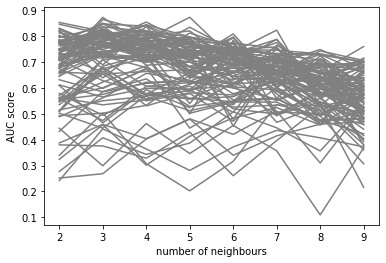

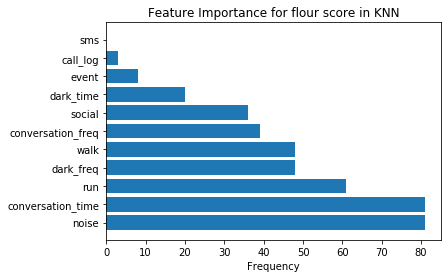

,dark_freq,walk,run,noise,conversation_time
uid,,,,,
u00,184.0,0.674377,0.193597,2.337681,26776.0
u01,205.0,0.427012,0.202807,2.206172,27783.0
u02,187.0,0.559020,0.012985,1.794788,20997.0
u03,64.0,0.112404,0.011857,0.434936,4225.0
u04,282.0,0.713760,0.296665,3.091217,26103.0
u05,170.0,0.344119,0.027820,1.868694,18123.0
u07,166.0,0.347257,0.133320,1.720642,14558.0
u09,191.0,0.526813,0.077314,1.701289,28590.0
u10,217.0,0.300647,0.084025,1.782517,19253.0


In [359]:
chosen = KNN_feature_selection(X_flour, label_flour, 'flour')
X_flour_chosen = X_flour.iloc[:, chosen]
X_flour_chosen

#### Positive Score

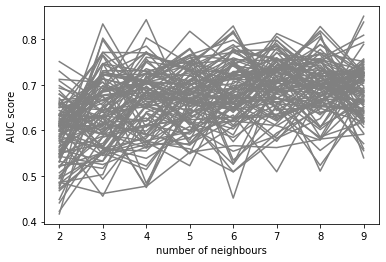

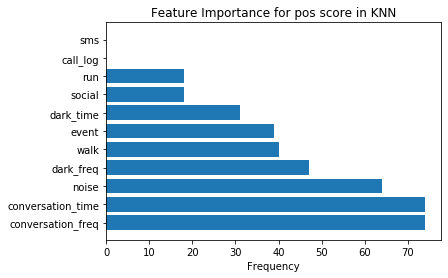

,walk,dark_freq,noise,conversation_freq,conversation_time
uid,,,,,
u00,0.674377,184.0,2.337681,2111.0,26776.0
u01,0.427012,205.0,2.206172,2179.0,27783.0
u02,0.559020,187.0,1.794788,1483.0,20997.0
u03,0.112404,64.0,0.434936,491.0,4225.0
u04,0.713760,282.0,3.091217,2873.0,26103.0
u05,0.344119,170.0,1.868694,1640.0,18123.0
u07,0.347257,166.0,1.720642,1483.0,14558.0
u09,0.526813,191.0,1.701289,2269.0,28590.0
u10,0.300647,217.0,1.782517,2260.0,19253.0


In [360]:
chosen = KNN_feature_selection(X_pos, label_pos, 'pos')
X_pos_chosen = X_pos.iloc[:, chosen]
X_pos_chosen

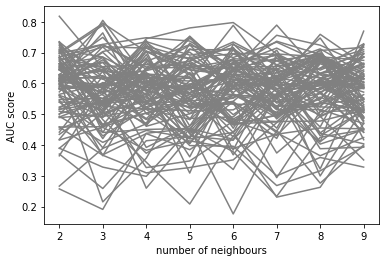

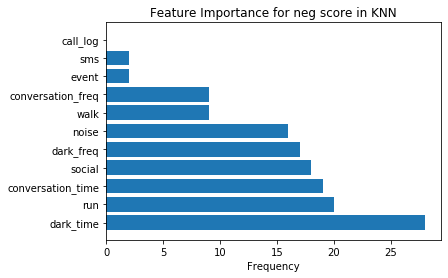

,dark_freq,social,conversation_time,run,dark_time
uid,,,,,
u00,184.0,44.886364,26776.0,0.193597,29424.0
u01,205.0,19.000000,27783.0,0.202807,41469.0
u02,187.0,20.950000,20997.0,0.012985,35508.0
u03,64.0,20.500000,4225.0,0.011857,14821.0
u04,282.0,28.000000,26103.0,0.296665,55879.0
u05,170.0,7.000000,18123.0,0.027820,36955.0
u07,166.0,25.000000,14558.0,0.133320,37579.0
u09,191.0,2.000000,28590.0,0.077314,35327.0
u10,217.0,31.000000,19253.0,0.084025,40111.0


In [361]:
chosen = KNN_feature_selection(X_neg, label_neg, 'neg')
X_neg_chosen = X_neg.iloc[:, chosen]
X_neg_chosen

### Evaluation

#### Flourishing Score

In [362]:
# ### Choose Features ###
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X_flour, label_flour)

# importance = clf.feature_importances_
# importance = pd.DataFrame(importance, index = X_flour.columns.to_numpy())
# importance.columns = ['importance']
# importance = importance.sort_values(by = ['importance'], ascending=False)
# plt.barh(importance.index, importance.iloc[:, 0])
# plt.title('Feature Importance for Flourishing Score in KNN')
# plt.savefig('./Images/knn_importance_flour.png', bbox_inches='tight')
# plt.show()
# #cols = chooseFeatures(importance)
# cols = importance.sort_values(by = 'importance', ascending = False).index[0:6].to_numpy()
# X_flour_chosen = X_flour.loc[:, cols]
# X_flour_chosen

0.7106428571428574


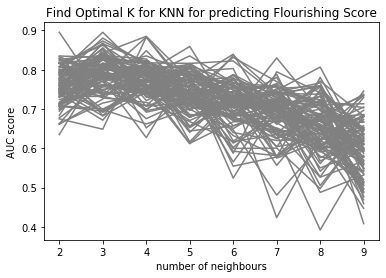

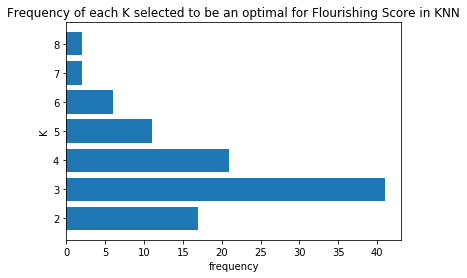

In [363]:
score = []
optimalK = []
for i in range(100):
    n = roc_auc_comparison(X_flour_chosen.to_numpy(), label_flour.to_numpy())
    optimalK.append(n)
    score.append(KNN(X_flour_chosen.to_numpy(), label_flour.to_numpy(), n))
#print(n)
print(np.array(score).mean())
plt.title('Find Optimal K for KNN for predicting Flourishing Score')
plt.savefig('./Images/k_flour.png', bbox_inches='tight')
plt.show()

temp = np.unique(np.array(optimalK),return_counts=True)
index = temp[0]
freq = temp[1]
#index, freq
plt.barh(index , freq)
plt.title('Frequency of each K selected to be an optimal for Flourishing Score in KNN')
plt.ylabel('K')
plt.xlabel('frequency')
path = './Images/knn_optimalK_four.png'
plt.savefig(path, bbox_inches='tight')
plt.show()

#### Positive Score

In [364]:
# ### Choose Features ###
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X_pos, label_pos)

# importance = clf.feature_importances_
# importance = pd.DataFrame(importance, index = X_pos.columns.to_numpy())
# importance.columns = ['importance']
# importance = importance.sort_values(by = ['importance'], ascending=False)
# plt.barh(importance.index, importance.iloc[:, 0])
# plt.title('Feature Importance for Positive Score in KNN')
# plt.savefig('./Images/knn_importance_pos.png', bbox_inches='tight')
# plt.show()
# cols = importance.sort_values(by = 'importance', ascending = False).index[0:4].to_numpy()

# X_pos_chosen = X_pos.loc[:, cols]

0.6543809523809524


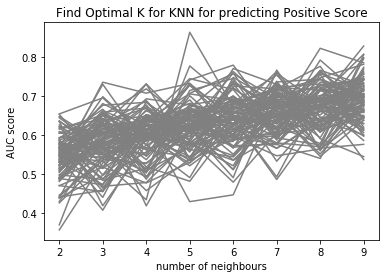

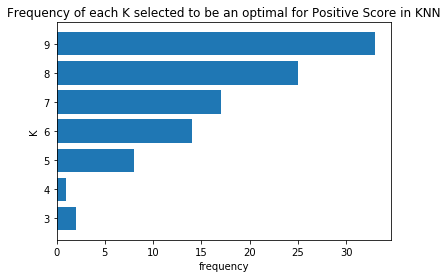

In [365]:
score = []
optimalK = []
for i in range(100):
    n = roc_auc_comparison(X_pos.to_numpy(), label_pos.to_numpy())
    optimalK.append(n)
    score.append(KNN(X_pos.to_numpy(), label_pos.to_numpy(), n))
print(np.array(score).mean())
plt.title('Find Optimal K for KNN for predicting Positive Score')
plt.savefig('./Images/k_positive.png', bbox_inches='tight')
plt.show()

temp = np.unique(np.array(optimalK),return_counts=True)
index = temp[0]
freq = temp[1]
#index, freq
plt.barh(index , freq)
plt.title('Frequency of each K selected to be an optimal for Positive Score in KNN')
plt.ylabel('K')
plt.xlabel('frequency')
path = './Images/knn_optimalK_pos.png'
plt.savefig(path, bbox_inches='tight')
plt.show()

#### Negative Score

In [366]:
# ### Choose Features ###
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X_neg, label_neg)

# importance = clf.feature_importances_
# importance = pd.DataFrame(importance, index = X_neg.columns.to_numpy())
# importance.columns = ['importance']
# importance = importance.sort_values(by = ['importance'], ascending=False)
# plt.barh(importance.index, importance.iloc[:, 0])
# plt.title('Feature Importance for Negative Score in KNN')
# plt.savefig('./Images/knn_importance_neg.png', bbox_inches='tight')
# plt.show()
# cols = importance.sort_values(by = 'importance', ascending = False).index[0:6].to_numpy()

# X_neg_chosen = X_neg.loc[:, cols]
# X_neg_chosen

0.5374880952380953


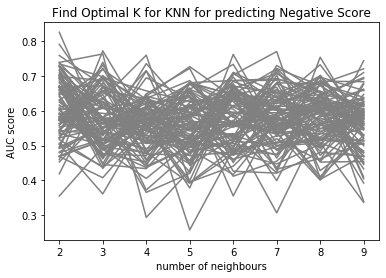

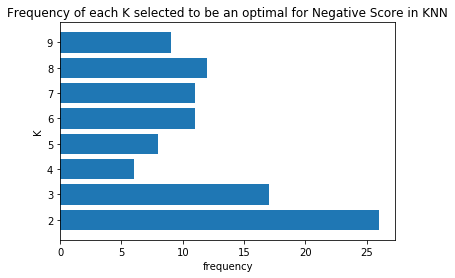

In [367]:
score = []
optimalK = []
for i in range(100):
    n = roc_auc_comparison(X_neg.to_numpy(), label_neg.to_numpy())
    optimalK.append(n)
    score.append(KNN(X_neg.to_numpy(), label_neg.to_numpy(), n))
print(np.array(score).mean())
plt.title('Find Optimal K for KNN for predicting Negative Score')
plt.savefig('./Images/k_negative.png', bbox_inches='tight')
plt.show()


temp = np.unique(np.array(optimalK),return_counts=True)
index = temp[0]
freq = temp[1]
#index, freq
plt.barh(index , freq)
plt.title('Frequency of each K selected to be an optimal for Negative Score in KNN')
plt.ylabel('K')
plt.xlabel('frequency')
path = './Images/knn_optimalK_neg.png'
plt.savefig(path, bbox_inches='tight')
plt.show()

## Method 3

In [42]:
# X_new = pd.DataFrame(columns = None)
# for key in inputs.keys():
#     if inputs[key].shape[1] ==10:
#         temp = inputs[key].loc[:, 'week10'].to_frame()
#         temp.columns = [key]
#         X_new = pd.concat([X_new, temp], axis = 1)
# X_new


# ## Look for people quit for post flourishing score testing ##
# full_ids = []
# for i in range(60):
#     full_ids.append('u' + str(f"{i:02d}"))
# ids_flour_post = df_flour_post.index.to_numpy()
# quit_ids = list(set(full_ids) - set(ids_flour_post))

# X_new = X_new.drop(quit_ids, errors='ignore')
# X_new

In [43]:
# ### Choose Features ###
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X_new, label_flour)
# cols = chooseFeatures(clf.feature_importances_)
# X_flour_chosen = X_new.iloc[:, cols]
# #X_flour_chosen
# accs = []
# for i in range(100):
#     n = roc_auc_comparison(X_flour_chosen.to_numpy(), label_flour.to_numpy())
#     accs.append(KNN(X_flour_chosen.to_numpy(), label_flour.to_numpy(), n))
# np.array(accs).mean()

In [325]:
X_flour

,dark_freq,social,walk,run,conversation_freq,noise,conversation_time,dark_time,event,call_log,sms
uid,,,,,,,,,,,
u00,184.0,44.886364,0.674377,0.193597,2111.0,2.337681,26776.0,29424.0,18.0,0.289151,0.074034
u01,205.0,19.000000,0.427012,0.202807,2179.0,2.206172,27783.0,41469.0,1.0,0.000000,0.000000
u02,187.0,20.950000,0.559020,0.012985,1483.0,1.794788,20997.0,35508.0,1.0,0.073098,0.703609
u03,64.0,20.500000,0.112404,0.011857,491.0,0.434936,4225.0,14821.0,3.0,0.000000,0.000000
u04,282.0,28.000000,0.713760,0.296665,2873.0,3.091217,26103.0,55879.0,3.0,0.000000,0.000000
u05,170.0,7.000000,0.344119,0.027820,1640.0,1.868694,18123.0,36955.0,0.0,0.000000,0.000000
u07,166.0,25.000000,0.347257,0.133320,1483.0,1.720642,14558.0,37579.0,2.0,0.000000,0.000000
u09,191.0,2.000000,0.526813,0.077314,2269.0,1.701289,28590.0,35327.0,0.0,0.000000,0.000000
u10,217.0,31.000000,0.300647,0.084025,2260.0,1.782517,19253.0,40111.0,9.0,0.000000,0.000000


### Random Forest 

In [326]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge

### Optimisation

In [412]:
def random_forest_validation(X, y, name, rang, score_type):
    train_score, validation_score = validation_curve(RandomForestClassifier(), X, y.to_numpy().ravel(), param_name=name,param_range=rang, cv=5)
    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_score, axis=1)
    train_std = np.std(train_score, axis=1)

    # Calculate mean and standard deviation for test set scores
    validation_mean = np.mean(validation_score, axis=1)
    validation_std = np.std(validation_score, axis=1)

    # Plot mean accuracy scores for training and test sets
    plt.plot(rang, train_mean, label="Training score", color="red")
    plt.plot(rang, validation_mean, label="Cross-validation score", color="blue")
#     print(rang)
    n = np.array(validation_mean).argmax()
#     print(n)
#     print(rang[n])
    # Plot accurancy bands for training and test sets
    plt.fill_between(rang, train_mean - train_std, train_mean + train_std, color="pink")
    plt.fill_between(rang, validation_mean - validation_std, validation_mean + validation_std, color="lightblue")

    # Create plot
    title = "Validation Curve With Random Forest for" + score_type
    plt.title(title)
    plt.xlabel(name)
    plt.ylabel("Accuracy Score")
    plt.tight_layout()
    plt.legend(loc="best")
    path = './Images/' + name + '_' + score_type + '.png'
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    return rang[n]

In [413]:
def optimiseRandomForest(X, label, score_type):
    rang = np.arange(1, 100, 2)
    name = "n_estimators"
    n_estimators = random_forest_validation(X, label, name, rang, score_type)
    rang = np.arange(2, 10, 1)
    name = "max_depth"
    max_depth = random_forest_validation(X, label, name, rang, score_type)
    rang = np.arange(2, 10, 1)
    name = "min_samples_split"
    min_samples_split = random_forest_validation(X, label,name, rang, score_type)
    rang = np.arange(2, 10, 1)
    name = "min_samples_leaf"
    min_samples_leaf = random_forest_validation(X, label,name, rang, score_type)
    return n_estimators, max_depth, min_samples_split, min_samples_leaf

#### Flourishing Score

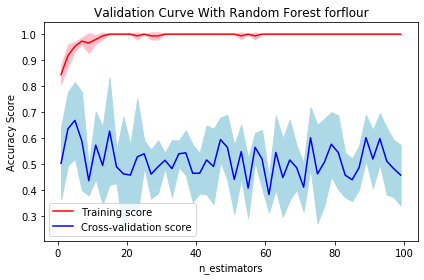

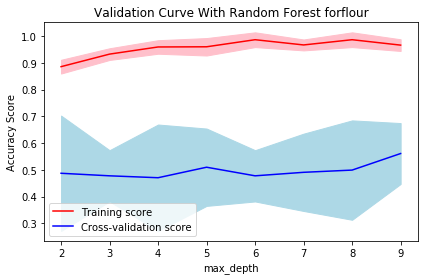

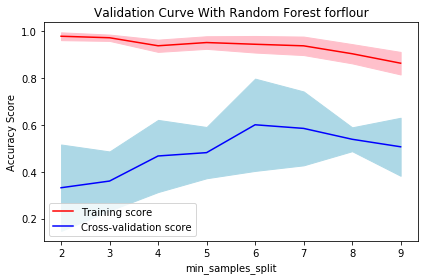

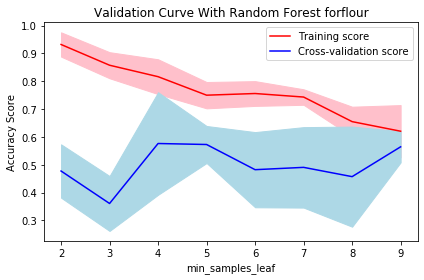

In [414]:
n_estimators, max_depth, min_samples_split, min_samples_leaf = optimiseRandomForest(X_flour, label_flour, 'flour')

In [415]:
X_flour_train, X_flour_valid, label_flour_train, label_flour_valid =  train_test_split(X_flour, label_flour, train_size=0.8)

5 9 6 4


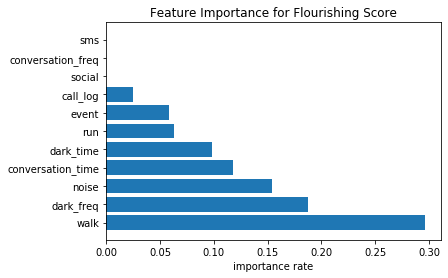

In [416]:
print(n_estimators, max_depth, min_samples_split, min_samples_leaf)
clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf = min_samples_leaf, random_state=0)
clf.fit(X_flour_train, label_flour_train)
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index = X_flour.columns.to_numpy())
importance.columns = ['importance']
importance = importance.sort_values(by = ['importance'], ascending=False)
plt.barh(importance.index, importance.iloc[:, 0])
plt.title('Feature Importance for Flourishing Score')
plt.xlabel('importance rate')
plt.savefig('./Images/random_importance_flour.png', bbox_inches='tight')
plt.show()

In [417]:
pred = clf.predict(X_flour_valid)
accuracy_score(label_flour_valid, pred)

0.25

#### Positive Score

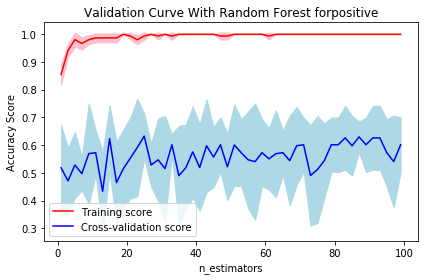

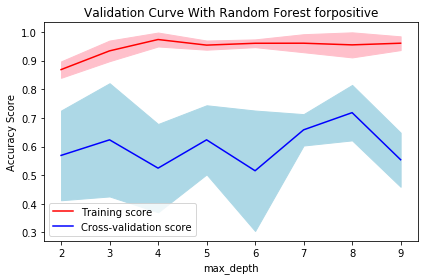

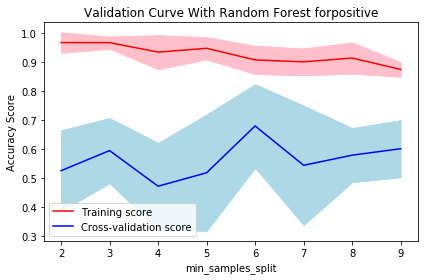

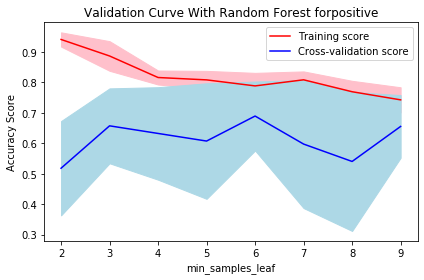

25 8 6 6


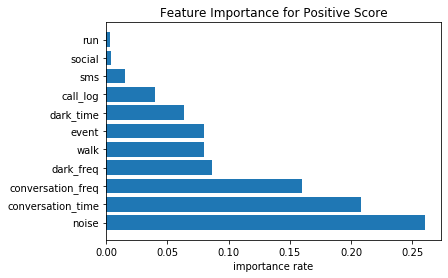

In [418]:
### Optimisation ###
X_pos_train, X_pos_valid, label_pos_train, label_pos_valid =  train_test_split(X_pos, label_pos, train_size=0.8)
n_estimators, max_depth, min_samples_split, min_samples_leaf = optimiseRandomForest(X_pos, label_pos, 'positive')

print(n_estimators, max_depth, min_samples_split, min_samples_leaf)
clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf = min_samples_leaf, random_state=0)
clf.fit(X_pos_train, label_pos_train)
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index = X_pos_train.columns.to_numpy())
importance.columns = ['importance']
importance = importance.sort_values(by = ['importance'], ascending=False)
plt.barh(importance.index, importance.iloc[:, 0])
plt.title('Feature Importance for Positive Score')
plt.xlabel('importance rate')
plt.savefig('./Images/random_importance_positive.png', bbox_inches='tight')
plt.show()

In [419]:
pred = clf.predict(X_pos_valid)
accuracy_score(label_pos_valid, pred)

0.5

#### Negative Scores

In [ ]:
### Optimisation ###
X_neg_train, X_neg_valid, label_neg_train, label_neg_valid =  train_test_split(X_neg, label_neg, train_size=0.8)
n_estimators, max_depth, min_samples_split, min_samples_leaf = optimiseRandomForest(X_neg, label_neg, 'negative')

print(n_estimators, max_depth, min_samples_split, min_samples_leaf)
clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf = min_samples_leaf, random_state=0)
clf.fit(X_neg_train, label_neg_train)
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index = X_neg_train.columns.to_numpy())
importance.columns = ['importance']
importance = importance.sort_values(by = ['importance'], ascending=False)
plt.barh(importance.index, importance.iloc[:, 0])
plt.title('Feature Importance for Negative Score')
plt.savefig('./Images/random_importance_negative.png', bbox_inches='tight')
plt.show()

In [ ]:
pred = clf.predict(X_neg_valid)
accuracy_score(label_neg_valid, pred)

## Method 4

### Get Hidden Gate from LSTM

### Naive Bayesian

In [ ]:
from sklearn.naive_bayes import BernoulliNB

In [56]:
### Normalisation ###
# df_sleep.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
# df_run.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
# df_walk.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
# df_conversation.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
# df_noise.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
# df_lock.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
# new_df_bt.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))

### BASED ON FACTOR ANALYSIS 

In [97]:
# factor1 = df_flour_post.iloc[:, 0].to_frame()
# factor1 = binarize(factor1, 5)

# acc = []
# for i in range(10):
#     X_flour_train, X_flour_valid, label_flour_train, label_flour_valid =  train_test_split(X_flour, factor1, train_size=0.8)
#     n_estimators, max_depth, min_samples_split, min_samples_leaf = optimiseRandomForest(X_flour_train, label_flour_train)
#     #print(n_estimators, max_depth, min_samples_split, min_samples_leaf)
#     clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf = min_samples_leaf, random_state=0)
#     clf.fit(X_flour_train, label_flour_train)
#     importance = clf.feature_importances_
#     importance = pd.DataFrame(importance, index = X_flour.columns.to_numpy())
#     importance.columns = ['importance']
#     importance = importance.sort_values(by = ['importance'], ascending=False)
#     pred = clf.predict(X_flour_valid)
#     acc.append(accuracy_score(label_flour_valid, pred))

In [98]:
# np.array(acc).mean()

In [87]:
# # new_df_lock = pd.DataFrame(columns = ['lock'])
# # new_df_conversation = pd.DataFrame(columns = ['conversation'])
# # new_df_walk = pd.DataFrame(columns = ['walk'])
# # new_df_run = pd.DataFrame(columns = ['run'])
# # new_df_sleep = pd.DataFrame(columns = ['sleep'])
# # new_df_bt = pd.DataFrame(columns=['frequency'])
# # new_df_wifi_location = pd.DataFrame(columns = ['location'])
# # df_bt = inputs['bluetooth'][0].set_index('uid')
# # new_df_noise = pd.DataFrame(columns=['noise'])
# # for uid in df_pos_pre.index:
# #     new_df_lock.loc[uid] = df_lock.loc[uid]
# #     new_df_conversation.loc[uid] = df_conversation.loc[uid]
# #     new_df_sleep.loc[uid] = df_sleep.loc[uid]
# #     new_df_bt.loc[uid] = df_bt.loc[uid]
# #     new_df_walk.loc[uid] = df_walk.loc[uid]
# #     new_df_run.loc[uid] = df_run.loc[uid]
# #     new_df_wifi_location.loc[uid] = df_wifi_location.loc[uid]
# #     new_df_noise.loc[uid] = df_noise.loc[uid]
# #new_df_bt
# # X = pd.concat([new_df_bt, new_df_conversation], axis = 1)
# #n_neighbour = roc_auc_comparison(X, df_pos_pre)
# # df = pd.DataFrame(columns = ['sum'])
# #df = df_flour_pre.iloc[:, 4:7].sum(axis=1)
# #df = pd.DataFrame(df, columns=['total'])
# df =df_flour_pre.iloc[:, 3:4]
# df.columns = ['total']

# # df
# df = binarize(df, 5)
# n_neighbour = roc_auc_comparison(X, df)
# KNN(X, df, n_neighbour=n_neighbour)

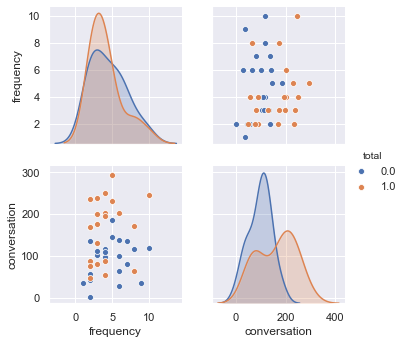

In [209]:
import seaborn as sns

X = X.astype('float')
tempX = pd.concat([X, df], axis = 1)
sns.set(color_codes=True)
var = list(tempX.columns)
var.remove('total')
sns.pairplot(tempX, hue = 'total', vars = var)
plt.show()

optimal k: 7
accuracy: 0.8


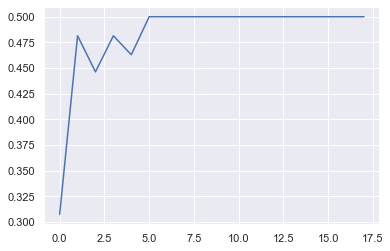

In [622]:
new_df_lock = pd.DataFrame(columns = ['lock'])
new_df_conversation = pd.DataFrame(columns = ['conversation'])
new_df_walk = pd.DataFrame(columns = ['walk'])
new_df_run = pd.DataFrame(columns = ['run'])
new_df_sleep = pd.DataFrame(columns = ['sleep'])
new_df_bt = pd.DataFrame(columns=['frequency'])
new_df_wifi_location = pd.DataFrame(columns = ['location'])
df_bt = inputs['bluetooth'][0].set_index('uid')
new_df_noise = pd.DataFrame(columns=['noise'])
for uid in df_flour_change.index:
    new_df_lock.loc[uid] = df_lock.loc[uid]
    new_df_conversation.loc[uid] = df_conversation.loc[uid]
    new_df_sleep.loc[uid] = df_sleep.loc[uid]
    new_df_bt.loc[uid] = df_bt.loc[uid]
    new_df_walk.loc[uid] = df_walk.loc[uid]
    new_df_run.loc[uid] = df_run.loc[uid]
    new_df_wifi_location.loc[uid] = df_wifi_location.loc[uid]
    new_df_noise.loc[uid] = df_noise.loc[uid]
    
#new_df_bt
X = pd.concat([new_df_sleep, new_df_wifi_location], axis = 1)
n_neighbour = roc_auc_comparison(X, df_flour_change)
#n_neighbour = accuracy_comparison(X, df_total_flour)
KNN(X, df_flour_change, n_neighbour=n_neighbour)

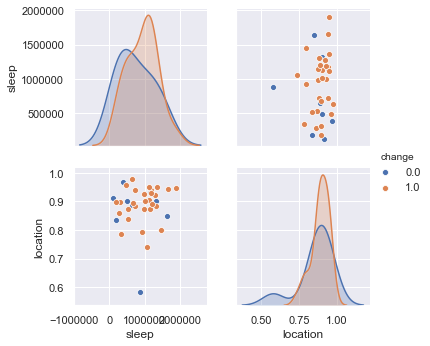

In [623]:
tempX = pd.concat([X, df_flour_change], axis = 1)
sns.set(color_codes=True)
var = list(tempX.columns)
var.remove('change')
sns.pairplot(tempX, hue = 'change', vars = var)
plt.show()

In [368]:
np.unique(df_total_flour, return_counts = True)
np.unique(df_class, return_counts = True)

(array([1., 3.]), array([22, 15]))

(array([1., 3.]), array([22, 15]))


([<matplotlib.patches.Wedge at 0x15cee37f0>,
 [Text(-0.3221050590501589, 1.0517834049528894, '1.0'),
  Text(0.3221050590501588, -1.0517834049528896, '3.0')])

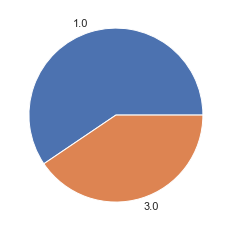

In [369]:
# classes
a = np.unique(df_class, return_counts=True)
print(a)
label = a[0]
y = a[1]
plt.pie(y, labels=label)

In [370]:
# new_df_lock = pd.DataFrame(columns = ['freq'])
# new_df_conversation = pd.DataFrame(columns = ['time'])
# new_df_sleep = pd.DataFrame(columns = ['time'])
# for uid in df_class.index:
#     new_df_lock.loc[uid] = df_lock.loc[uid]
#     new_df_conversation.loc[uid] = df_conversation.loc[uid]
#     new_df_sleep.loc[uid] = df_sleep.loc[uid]
# # n_neighbour = roc_auc_comparison(X, df_class)
# # KNN(X, df_class, n_neighbour)
# X_train, X_test, y_train, y_test = train_test_split(X, df_class.to_numpy().ravel(), random_state=10)
# clf = BernoulliNB()
# clf.fit(X_train,y_train)
# pred = clf.predict(X_test)
# pred = pred.astype(int)
# pred

In [371]:
y_test = y_test.astype(int)
y_test
print(y_test)

print(accuracy_score(y_test, pred))

NameError: name 'y_test' is not defined

In [373]:
#inputs[''][2].head(50)

In [374]:
inputs.keys()

dict_keys(['wifi', 'gps', 'activity', 'phonelock', 'wifi_location', 'audio', 'bluetooth', 'dark', 'phonecharge', 'conversation'])

In [466]:
X = X.astype(dtype = 'float')
## correlation ##
c = X.corr()
c

,conversation,walk
conversation,1.000000,0.546159
walk,0.546159,1.000000


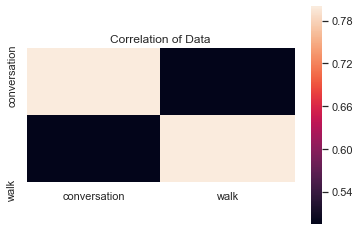

In [456]:
import seaborn as sns
sns.heatmap(c, vmax=.8, square=True)
plt.title("Correlation of Data")
plt.show()

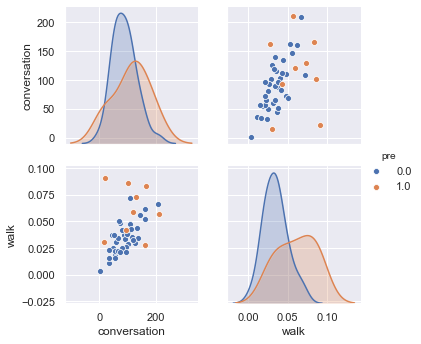

In [457]:
tempX = pd.concat([X, df_pos_pre], axis = 1)
sns.set(color_codes=True)
var = list(tempX.columns)
var.remove('pre')
sns.pairplot(tempX, hue = 'pre', vars = var)
plt.show()

In [145]:
df_flour_pre

,I lead a purposeful and meaningful life,My social relationships are supportive and rewarding,I am engaged and interested in my daily activities,I actively contribute to the happiness and well-being of others,I am competent and capable in the activities that are important to me,I am a good person and live a good life,I am optimistic about my future,People respect me
uid,,,,,,,,
u00,7,6,NaN,6.0,6.0,7.0,7,4
u01,4,6,6.0,6.0,7.0,6.0,4,6
u02,6,7,5.0,6.0,5.0,6.0,4,7
u03,6,2,2.0,4.0,5.0,6.0,5,4
u04,3,5,4.0,3.0,2.0,2.0,3,5
u05,6,6,6.0,6.0,6.0,6.0,6,6
u07,7,5,6.0,5.0,7.0,7.0,7,5
u08,5,5,5.0,5.0,5.0,NaN,4,4
u09,5,4,6.0,6.0,6.0,7.0,7,5


In [146]:
df_pos_pre

,Interested,Strong,Enthusiastic,Proud,Alert,Inspired,Determined,Attentive,Active
uid,,,,,,,,,
u00,5,4,3,3,4,4.0,4,3.0,2
u01,4,2,3,3,4,3.0,4,3.0,4
u02,4,2,3,2,3,2.0,2,3.0,2
u03,4,4,3,1,5,3.0,3,3.0,4
u04,4,3,3,3,3,1.0,3,3.0,4
u05,4,4,4,2,4,3.0,3,4.0,4
u07,3,4,4,5,3,2.0,3,3.0,3
u08,3,3,3,3,3,3.0,5,3.0,4
u09,4,3,3,3,3,2.0,3,3.0,4


In [ ]:
# ### Componenet Analysis on flourishing score ###
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(df_flour)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
# principalDf
# pca.explained_variance_ratio_

# ### Componenet Analysis on positive score ###
# df_pos = df_pos.fillna(0)
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(df_pos)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
# principalDf
# pca.explained_variance_ratio_

# ### Componenet Analysis on negative score ###
# df_neg = df_neg.fillna(0)
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(df_neg)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
# principalDf
# pca.explained_variance_ratio_